# Question Type Classification Baselines: (S)TF-IDF Baseline Experiments
#### Multilingual Question Type Classification and Complexity Prediction

In this notebook we will be developing a set of baselines for question type classification using subword TF-IDF vectors generated with the text2text toolkit. 

##### Author: Robin Kokot
##### Date: March 2025


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Setup and Data Loading

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from datasets import load_dataset
import wandb
import logging
import time
import os

# ==================== Set up displays

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

# ==================== Set up seed constant

SEED = 69
np.random.seed(SEED)

In [28]:
# ==================== Wandb config
run = wandb.init(project="MAIthesis", name="xgboost-clf-baseline", tags=["baseline", "xgboost", "question-classification", "tfidf"], job_type="model-training")

config = wandb.config
config.max_depth = 6
config.learning_rate = 0.3
config.n_estimators = 100
config.objective = 'binary:logistic'
config.random_state = 69
config.subsample = 0.8
config.colsample_bytree = 0.8
config.eval_metric='error'


wandb.run.notes = "Baseline experiments with polar vs. content question type classification using XGBoost classifier on subword TF-IDF vectors"

In [29]:
# ==================== Dataset loading and label config
dataset = load_dataset("rokokot/question-type-and-complexity-v2")

y_train = np.array(dataset['train']['question_type'])     # target labels
y_dev = np.array(dataset['validation']['question_type'])
y_test= np.array(dataset['test']['question_type'])

print(f"Train label distribution: {np.bincount(y_train)}")
print(f"Test label distribution: {np.bincount(y_test)}")
print(f"Validation label distribution: {np.bincount(y_dev)}")
  

Train label distribution: [3778 3682]
Test label distribution: [367 352]
Validation label distribution: [223 218]


In [34]:
# ==================== TFIDF vectors loading
train_vectors = "/home/robin/Research/qtype-eval/scripts/baselines/vectors/tfidf_vectors_train.pkl"
dev_vectors = "/home/robin/Research/qtype-eval/scripts/baselines/vectors/tfidf_vectors_dev.pkl"
test_vectors = "/home/robin/Research/qtype-eval/scripts/baselines/vectors/tfidf_vectors_test.pkl"

with open(train_vectors, 'rb') as v:        # text feature vectors
  X_train = pickle.load(v)
with open(dev_vectors, 'rb') as v:
  X_dev = pickle.load(v)

with open(test_vectors, 'rb') as v:
  X_test = pickle.load(v)

print("\nchecking shapes of features and labels:")
print(f"Train - Features: {X_train.shape[0]}, Labels: {y_train.shape[0]}")
print(f"Test - Features: {X_test.shape[0]}, Labels: {y_test.shape[0]}")
print(f"Validation - Features: {X_dev.shape[0]}, Labels: {y_dev.shape[0]}")
    


checking shapes of features and labels:
Train - Features: 7460, Labels: 7460
Test - Features: 719, Labels: 719
Validation - Features: 441, Labels: 441


In [37]:
print("X_train type:", type(X_train))
if hasattr(X_train, 'shape'):
    print("X_train shape:", X_train.shape)
elif isinstance(X_train, list):
    print("X_train is a list of length:", len(X_train))
    print("First element type:", type(X_train[0]))

import numpy as np
from scipy.sparse import vstack

# Extract sparse matrices from the array and stack them
sparse_matrices = [matrix[0] for matrix in X_train]  # Assuming each row has a single element
X_train_stacked = vstack(sparse_matrices)

sparse_matrices = [matrix[0] for matrix in X_dev]  # Assuming each row has a single element
X_dev_stacked = vstack(sparse_matrices)

# Same for test data
sparse_matrices_test = [matrix[0] for matrix in X_test]
X_test_stacked = vstack(sparse_matrices_test)

X_train type: <class 'numpy.ndarray'>
X_train shape: (7460, 1)


In [38]:
# ==================== XGBoost Training and Evaluation
xgb_clf = xgb.XGBClassifier(
    max_depth=config.max_depth,
    learning_rate=config.learning_rate,
    n_estimators=config.n_estimators,
    objective=config.objective,
    random_state=config.random_state,
    subsample=config.subsample,
    colsample_bytree=config.colsample_bytree,
    eval_metric=config.eval_metric
)

wandb.config.update({
  "model_type": "XGBoost",
  "feature_type": "TF-IDF",
  "train_samples": X_train_stacked.shape[0],    # number of rows
  "test_samples": X_test_stacked.shape[0],
  "dev_samples": X_dev_stacked.shape[0],
  "feature_dim": X_train_stacked.shape[1]       # number of columns
})

In [40]:

start_time = time.time()

xgb_clf.fit(X_train_stacked, y_train, eval_set=[(X_train_stacked, y_train), (X_dev_stacked, y_dev)], verbose=50)

training_time = time.time() - start_time
print(f"training took {training_time:.2f} seconds")
wandb.log({"training_time": training_time})

[0]	validation_0-error:0.26233	validation_1-error:0.31293
[50]	validation_0-error:0.03338	validation_1-error:0.14739
[99]	validation_0-error:0.01609	validation_1-error:0.12245
training took 196.50 seconds



Evaluating model on development set...
Dev Set: Accuracy = 0.8776, F1 Score = 0.8773
Confusion Matrix (Dev Set):
[[194  29]
 [ 25 193]]


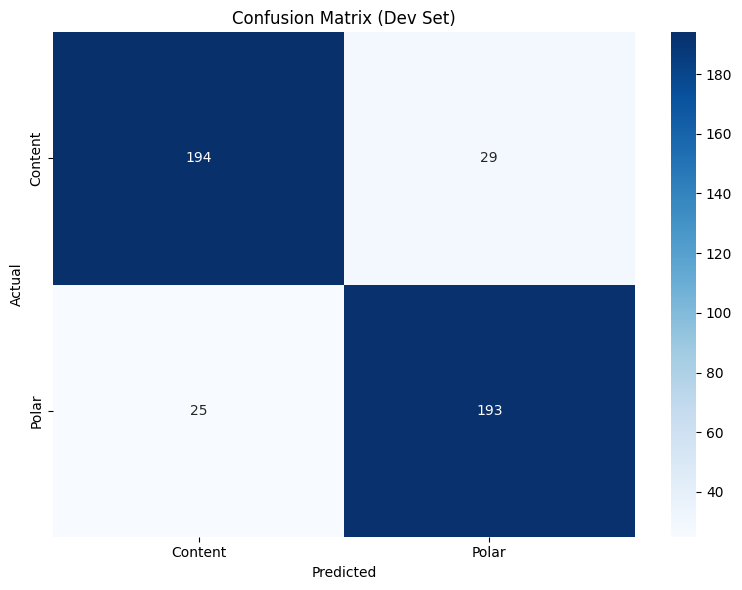

In [41]:
# ==================== Model evaluation
print("\nEvaluating model on development set...")
y_pred_dev = xgb_clf.predict(X_dev_stacked)
y_pred_proba_dev = xgb_clf.predict_proba(X_dev_stacked)[:, 1]

accuracy_dev = accuracy_score(y_dev, y_pred_dev)
precision_dev, recall_dev, f1_dev, _ = precision_recall_fscore_support(y_dev, y_pred_proba_dev > 0.5, average='binary')

print(f"Dev Set: Accuracy = {accuracy_dev:.4f}, F1 Score = {f1_dev:.4f}")

cm_dev = confusion_matrix(y_dev, y_pred_dev)
print("Confusion Matrix (Dev Set):")
print(cm_dev)

wandb.log({"dev_accuracy": accuracy_dev, "dev_precision": precision_dev, "dev_recall":recall_dev, "dev_f1": f1_dev})

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues',xticklabels=['Content', 'Polar'],  yticklabels=['Content', 'Polar'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Dev Set)')
plt.tight_layout()
wandb.log({"dev_confusion_matrix": wandb.Image(plt)})






Evaluating model on test set...
Test Set: Accuracy = 0.7761, F1 Score = 0.7895
Confusion Matrix (Test Set):
[[256 111]
 [ 50 302]]


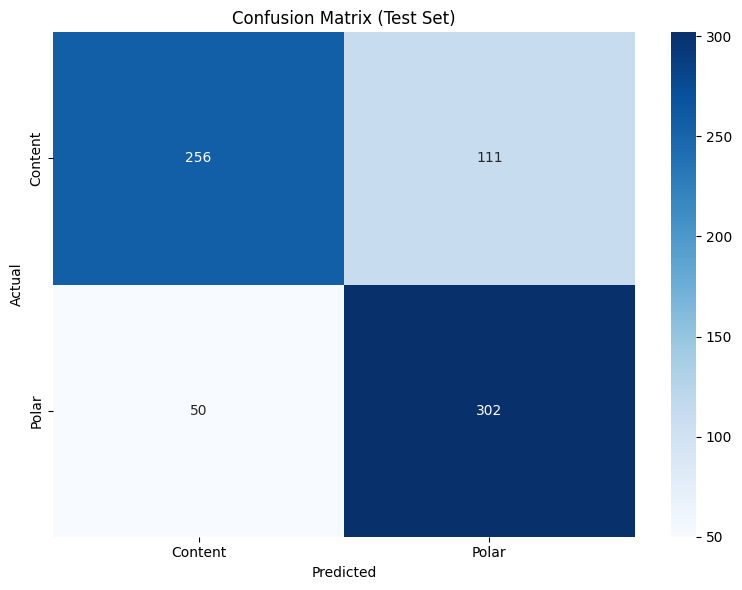

In [42]:
# ==================== Evaluating on test set
print("\nEvaluating model on test set...")
y_pred_test = xgb_clf.predict(X_test_stacked)
y_pred_proba_test = xgb_clf.predict_proba(X_test_stacked)[:, 1]

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_proba_test > 0.5, average='binary')
print(f"Test Set: Accuracy = {accuracy_test:.4f}, F1 Score = {f1_test:.4f}")

cm_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test Set):")
print(cm_test)
wandb.log({"test_accuracy": accuracy_test,"test_precision": precision_test,"test_recall": recall_test,"test_f1": f1_test})

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Content', 'Polar'], yticklabels=['Content', 'Polar'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
wandb.log({"test_confusion_matrix": wandb.Image(plt)})


Analyzing feature importance...
Top 20 important features:
        feature_index  importance
86932           86932    0.037190
14529           14529    0.036031
1779             1779    0.033070
545               545    0.027282
1996             1996    0.027063
12432           12432    0.026306
47503           47503    0.024852
24                 24    0.019314
177               177    0.017575
45841           45841    0.016803
9007             9007    0.016718
66274           66274    0.016597
149               149    0.016276
67398           67398    0.015669
121905         121905    0.014888
34226           34226    0.014569
1513             1513    0.014421
16990           16990    0.013240
3018             3018    0.012751
117               117    0.012584


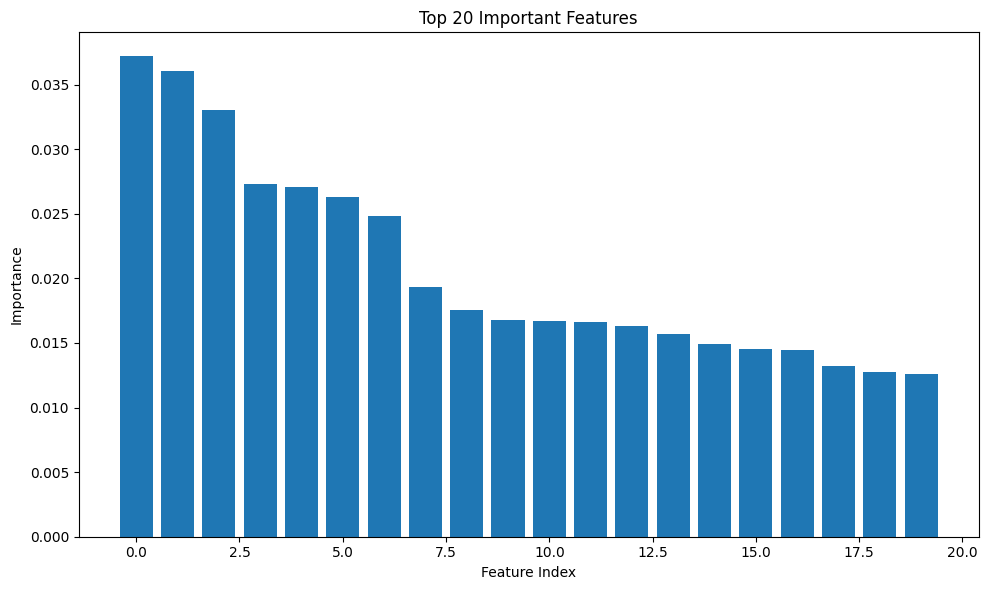

In [43]:
# ==================== Feature Importance Analysis
print("\nAnalyzing feature importance...")
importance = xgb_clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature_index': range(len(importance)),
    'importance': importance
}).sort_values('importance', ascending=False)

top_features = feature_importance_df.head(20)
print("Top 20 important features:")
print(top_features)

plt.figure(figsize=(10, 6))
plt.bar(range(20), top_features['importance'])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 20 Important Features')
plt.tight_layout()
wandb.log({"feature_importance": wandb.Image(plt)})
wandb.log({"feature_importance_table": wandb.Table(
    data=[[int(idx), float(imp)] for idx, imp in zip(top_features['feature_index'], top_features['importance'])],
    columns=["feature_index", "importance"])
})

In [44]:
# ==================== Save Model
model_path = 'xgboost_baseline_model.json'
xgb_clf.save_model(model_path)

wandb.save(model_path)

['/home/robin/Research/qtype-eval/scripts/baselines/wandb/run-20250323_142854-wk6sk7p2/files/xgboost_baseline_model.json']

In [ ]:
# add analysis by language

In [ ]:
# plot roc and learning curves

In [ ]:
# add hyperparameter tuning

In [45]:
wandb.finish()

dev_accuracy,▁
dev_f1,▁
dev_precision,▁
dev_recall,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
training_time,▁
dev_accuracy,0.87755
dev_f1,0.87727
